In [1]:
import os
import sys
sys.path.append("../")
import argparse
import time
import pickle
from AliMisc import *
from model import *
from AliLoader import *
from sklearn import metrics
from sklearn import manifold
import seaborn as sns
import pandas as pd

In [2]:

LS = 512 #Latent Space Size
ColorsNumber = 1 #Number of color (always 1 for x-ray)
isize = 64
inputsize = 64
name = "Exp_64_512_0.00001_RandomLabel_4.0_nofinding"

datadir = "/media/vince/MILA/Chest_data/"

ExpDir = "/media/vince/MILA/ChestXrays/ALI/model/"+name
print(ExpDir+"/images/RecLoss")
if not os.path.exists(ExpDir+"/images/RecLoss"):
    print(bla)
    os.makedirs(ExpDir+"/images/RecLoss")

/media/vince/MILA/ChestXrays/ALI/model/Exp_64_512_0.00001_RandomLabel_4.0_nofinding/images/RecLoss


In [3]:
#Load train and test

TestDataset = LoadTrainTestSet(datadir+"ChestXray-NIHCC-2/",inputsize,rseed=13,subset="Test")
TrainDataset = LoadTrainTestSet(datadir+"ChestXray-NIHCC-2/",inputsize,rseed=13,N=len(TestDataset))
#Load MNIST
MNIST = LoadMNIST(datadir+"MNIST/",inputsize)

#Load MURA
MURA = LoadMURA(datadir+"MURA-v1.1/*/",inputsize,N=len(TestDataset),rseed=13)

#Load Pneunomia
Pneuno = LoadPneunomia(datadir+"/chest_xray/*/*",inputsize,N=len(TestDataset),rseed=13)

#Modified Chest X-ray 
Hflip,Vflip,Shuffle,Random = LoadModChest(datadir+"ChestXray-NIHCC-2/",64,rseed=13)



In [4]:
DsetName = ["ChestXray","tChestXray","MNIST","MURA","Pneuno","hFlip","vFlip","Shuffle","Random"]
Dset = [TestDataset,TrainDataset,MNIST,MURA,Pneuno,Hflip,Vflip,Shuffle,Random]

In [5]:
#Get all Modeled saved
SavedModelsIT = []
for SavedFiles in glob.glob('{0}/models/*_DisXZ_It_*.pth'.format(ExpDir)):
    #print(fck)
    nck = SavedFiles.split("_")[-1].split(".")[0]
    SavedModelsIT.append(int(nck))
SavedModelsIT = sorted(SavedModelsIT)
print("Saved Model",SavedModelsIT)

Saved Model [525000]


In [6]:
def EvalImage(GenX,GenZ,DisXZ,DisX,DisZ,ConstantX):
    
    #Generate Latent from Real
    RealZ = GenZ(ConstantX)
    RebuildX = GenX(RealZ)

    DiffX = ConstantX - RebuildX

    #Have discriminator do is thing on real and fake data
    PredReal  = DisXZ(torch.cat((DisZ(RealZ), DisX(ConstantX)), 1))
    if torch.cuda.is_available():
        DiffX = DiffX.cpu()
        RebuildX = RebuildX.cpu()
        PredReal = PredReal.cpu()
        RealZ = RealZ.cpu()

    PredReal = PredReal.detach().numpy()
    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RebuildX = RebuildX.detach().numpy()
    RealZ = RealZ.detach().numpy()
    RealZ.resize((RealZ.shape[:2]))
    
    DiscSC = list(np.ravel(PredReal))
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]
    
    return(DiscSC,RecLoss,list(RealZ),RebuildX,DiffX)
        

In [7]:
def RecLoss(GenX,GenZ,X):
    GenX.eval()
    GenZ.eval()
    Z = GenZ(X)
    Xr = GenX(Z)
    
    DiffX = Xr - X
    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RecLoss = [np.sqrt(np.mean(x)) for x in DiffX]
    Xr = Xr.detach().numpy()
    Z = Z.detach().numpy()
    Z = Z.reshape(Z.shape[0],Z.shape[1])
    return(RecLoss,DiffX,Xr,Z)

In [8]:
isize,inputsize

(64, 64)

In [9]:
DisX,DisZ,DisXZ,GenZ,GenX,CP,DiscriminatorLoss,AllAUCs = GenModel(isize,LS,-2,ExpDir,name,ColorsNumber=ColorsNumber)


I found this last checkpoint 525000
Checkpoint 525000 exist, will load param and start training from there
/media/vince/MILA/ChestXrays/ALI/model/Exp_64_512_0.00001_RandomLabel_4.0_nofinding/models/Exp_64_512_0.00001_RandomLabel_4.0_nofinding_DisX_It_525000.pth


In [10]:
AllAUCs = dict()
for cp in sorted(SavedModelsIT):
    #Load current iteration
    
    DisX,DisZ,DisXZ,GenZ,GenX,CP,DiscriminatorLoss,tAUCs = GenModel(
        isize,LS,cp,ExpDir,name,ColorsNumber=ColorsNumber)
    print("Iterations",cp,CP)
    
    
    
    #Set to eval
    GenX.eval()
    GenZ.eval()
    DisX.eval()
    DisZ.eval()
    DisXZ.eval()
    
    #Where to Store data
    AllEvalData = dict()
    for (d,n) in zip(Dset,DsetName):
        print(n)
        AllEvalData[n] = dict()
        #Array to store data
        TDiscSc = []
        TRecErr = []
        TZ = []
        TX = []
        TXr = []
        TDiff = []
        tlab = []
        for Xi,path in DataLoader(d,shuffle=False, batch_size=50):
            rXi = Xi*2.0-1.0
            if torch.cuda.is_available():
                rXi = rXi.cuda()
            ttlab = []
            if n == "MNIST":
                ttlab = list(path.detach().numpy())
            else:
                ttlab += list(path[1])
            #Calculate Error    
            DiscSc,RL,Z,Xr,DiffX = EvalImage(GenX,GenZ,DisXZ,DisX,DisZ,rXi)
            
            #Store everything
            if torch.cuda.is_available():
                Xi = Xi.cpu()
                
            TX += list(Xi.detach().numpy())
            TDiscSc += DiscSc
            TRecErr += RL
            TZ += Z
            TXr += list(Xr)
            TDiff += list(DiffX)
            tlab += ttlab
            test_size = len(TestDataset)
            if len(TZ) >= test_size:
                TZ = TZ[:test_size]
                TX = TX[:test_size]
                TDiscSc = TDiscSc[:test_size]
                TRecErr = TRecErr[:test_size]
                TXr  = TXr[:test_size]
                TDiff  = TDiff[:test_size]
                tlab = tlab[:test_size]
                break
    
        AllEvalData[n]["Z"] = TZ
        AllEvalData[n]["X"] = TX
        AllEvalData[n]["RecLoss"] = TRecErr
        AllEvalData[n]["Dis"] = TDiscSc
        AllEvalData[n]["Xr"] = TXr
        AllEvalData[n]["DiffX"] = TDiff
        AllEvalData[n]["lab"] = tlab
    
    #Print Reconstruction process
    sf = ExpDir+"/images/RecLoss/Recon_"+"%010d.png" % (cp)
    ImageReconPrint(AllEvalData,DsetName,SaveFile=sf)
    
    #Print Distribution of image
    sf = ExpDir+"/images/RecLoss/ImgDist_"+"%010d.png" % (cp)
    PrintDense(AllEvalData,DsetName,ToPrint=["ChestXray","MNIST","MURA","Pneuno"],SaveFile=sf)
    sf = ExpDir+"/images/RecLoss/SynthDist_"+"%010d.png" % (cp)
    PrintDense(AllEvalData,DsetName,ToPrint=["ChestXray","hFlip","vFlip","Shuffle","Random","tChestXray"],SaveFile=sf)
    
    #Print Sorted error
    sf = ExpDir+"/images/RecLoss/SortErr_"+"%010d.png" % (cp)
    ImageSortPrint(AllEvalData,DsetName,SaveFile=sf)
    tAUC = GetAUC(AllEvalData,metric="RecLoss")
    AllAUCs[cp] = tAUC
    
    #Print T-SNE
    df = GetTSNE(AllEvalData,ToPrint = ["ChestXray","MNIST","MURA","Pneuno","Shuffle","vFlip"])
    sf = ExpDir+"/images/RecLoss/TSNE_"+"%010d.png" % (cp)
    PrintTSNE(df,ToPrint = ["ChestXray","MNIST","MURA","Pneuno","Shuffle","vFlip"],MaxPlot=300,SaveFile=sf)
    break

Checkpoint 525000 exist, will load param and start training from there
/media/vince/MILA/ChestXrays/ALI/model/Exp_64_512_0.00001_RandomLabel_4.0_nofinding/models/Exp_64_512_0.00001_RandomLabel_4.0_nofinding_DisX_It_525000.pth
Iterations 525000 525000
ChestXray
tChestXray
MNIST
MURA
Pneuno
hFlip
vFlip
Shuffle
Random


/media/vince/anaconda3/envs/xray/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [11]:
tAUC

{'tChestXray': 0.4576691489282718,
 'MNIST': 1.0,
 'MURA': 0.902768600256888,
 'Pneuno': 0.8196660454825562,
 'hFlip': 0.5593181328839029,
 'vFlip': 0.517065239180631,
 'Shuffle': 0.9612885981780249,
 'Random': 0.608713406440021}

In [12]:
def PrintTSNE(df,ToPrint = [],SaveFile="NA",MaxPlot = -1,size=20):

    fig = plt.figure(figsize=(15.5,8))
    SNScol = sns.color_palette()
    if len(ToPrint) == 0:
        ToPrint = list(df["Lab"].value_counts().index)
    for i,name in enumerate(ToPrint):
        subdf = df[df["Lab"] == name]
        xi = subdf["T-SNE1"]
        yi = subdf["T-SNE2"]
        if MaxPlot > 0:
            xi = xi[:MaxPlot]
            yi = yi[:MaxPlot]
        if len(ToPrint) != 0:
            if name not in ToPrint:
                continue
        
        plt.scatter(xi,yi,label=name,s=size,color=SNScol[i],alpha=0.7,edgecolors="none")
    #plt.legend(loc='center left',fontsize = 15,frameon=False, markerscale=2,bbox_to_anchor=(1, 0.5))
    plt.legend(fontsize = 15,frameon=False, markerscale=2)
    if SaveFile != "NA":
        fig.savefig(SaveFile)
    else:
        plt.show()
    plt.close('all')
    
    if 1 == 0:
        fig = plt.figure(figsize=(15.5,8))
        for i,name in enumerate(sorted(df["Lab"].unique())):
            subdf = df[df["Lab"] == name]
            xi = subdf["T-SNE1"]
            yi = subdf["T-SNE2"]
            rl = subdf["RL"]
            if MaxPlot > 0:
                xi = xi[:MaxPlot]
                yi = yi[:MaxPlot]
                rl = rl[:MaxPlot]
            if len(ToPrint) != 0:
                if name not in ToPrint:
                    continue
            plt.scatter(xi,yi,cmap=plt.cm.coolwarm,c=rl,s=20,alpha=0.7)
        plt.colorbar()
        plt.show()

        

        

#PrintTSNE(df,ToPrint = ["ChestXray","hFlip","vFlip","Shuffle","Random","tChestXray"])
#PrintTSNE(df,MaxPlot=300)

In [13]:
def GetTSNE(AllEvalData,ToPrint = []):
    AllZ = []
    lab = []
    rl = []
    imglab = []
    for name in sorted(AllEvalData.keys()):
        if "Z" not in AllEvalData[name]:continue
        if len(ToPrint) != 0:
            if name not in ToPrint:
                continue
        AllZ += AllEvalData[name]["Z"]
        lab += [name]*len(AllEvalData[name]["Z"])
        rl += list(AllEvalData[name]["RecLoss"])
        imglab += list(AllEvalData[name]["lab"])
    Y = manifold.TSNE(n_components=2).fit_transform(AllZ)
    df = pd.DataFrame([Y[:,0],Y[:,1],lab,rl,imglab]).transpose()
    df.columns = ["T-SNE1","T-SNE2","Lab","RL","ImgLab"]
    return(df)



In [14]:
df

,T-SNE1,T-SNE2,Lab,RL,ImgLab
0,4.37739,26.9054,ChestXray,0.585878,effusion
1,-27.0443,26.8099,ChestXray,0.540093,effusion_infiltration
2,-21.7003,21.7434,ChestXray,0.592605,fibrosis
3,-24.8046,22.557,ChestXray,0.423658,pneumothorax
4,20.329,45.5956,ChestXray,0.555798,infiltration
5,-22.5831,10.2522,ChestXray,0.471756,no_finding
6,2.17058,28.2907,ChestXray,0.478251,pneumothorax
7,-22.7082,8.97241,ChestXray,0.561552,atelectasis_infiltration
8,41.6773,20.826,ChestXray,0.642744,no_finding
9,-22.5365,29.526,ChestXray,0.518167,no_finding


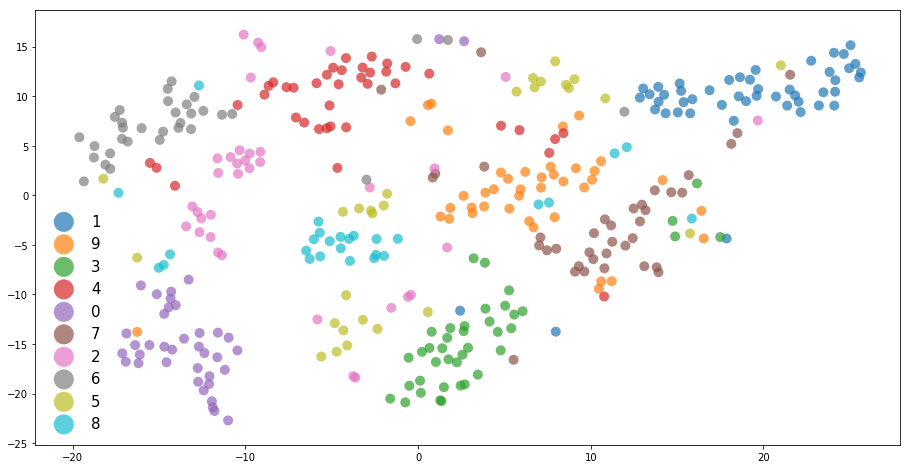

IndexError: list index out of range

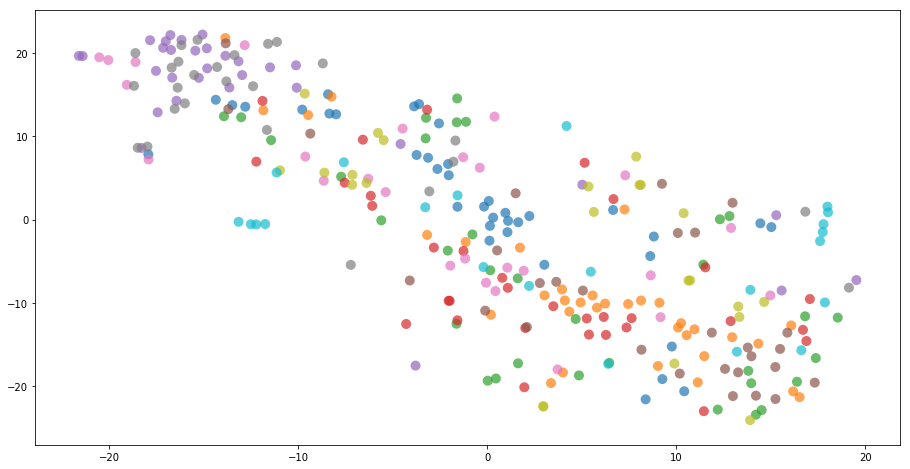

In [15]:
df = GetTSNE(AllEvalData,ToPrint = ["MNIST"])
subdf = df[df["Lab"] == "MNIST"]
subdf["Lab"] = subdf["ImgLab"]
PrintTSNE(subdf,MaxPlot=300,size=100)

df = GetTSNE(AllEvalData,ToPrint = ["MURA"])
subdf = df[df["Lab"] == "MURA"]
subdf["Lab"] = subdf["ImgLab"]
PrintTSNE(subdf,MaxPlot=300,size=100)

df = GetTSNE(AllEvalData,ToPrint = ["ChestXray"])
subdf = df[df["Lab"] == "ChestXray"]
subdf["Lab"] = subdf["ImgLab"] == "no_finding"
PrintTSNE(subdf,MaxPlot=300,size=100)

In [16]:
subdf

,T-SNE1,T-SNE2,Lab,RL,ImgLab
0,1.6396,-0.310254,negative_HAND,0.852769,negative_HAND
1,17.0647,-9.535,positive_WRIST,0.986568,positive_WRIST
2,17.0935,-1.50294,positive_HUMERUS,0.821866,positive_HUMERUS
3,-13.1546,19.012,negative_SHOULDER,0.50826,negative_SHOULDER
4,16.2215,-18.1137,negative_FOREARM,1.00923,negative_FOREARM
5,1.61342,-7.04937,negative_WRIST,0.927821,negative_WRIST
6,5.15294,6.82982,positive_WRIST,0.802075,positive_WRIST
7,13.9727,-16.4036,negative_FINGER,1.00482,negative_FINGER
8,12.8106,0.427233,negative_WRIST,0.678493,negative_WRIST
9,12.3541,-11.433,positive_HUMERUS,1.06063,positive_HUMERUS


In [19]:

df = GetTSNE(AllEvalData,ToPrint = ["MURA"])
subdf = df[df["Lab"] == "MURA"]
subdf["Lab"] = subdf["ImgLab"]
AllNer = []
AllRand = []
for i in range(len(subdf)):
    close = np.power((subdf[["T-SNE1","T-SNE2"]] - subdf.loc[i][["T-SNE1","T-SNE2"]]),2).sum(axis=1).sort_values().index[1]
    k = " ".join(sorted([str(subdf["Lab"][close]),str(subdf["Lab"][i])]))
    AllNer.append(k)
    
    k = " ".join(sorted([str(subdf["Lab"][np.random.randint(len(subdf))]),str(subdf["Lab"][i])]))
    AllRand.append(k)


In [20]:
pd.Series(AllNer).value_counts()

negative_SHOULDER positive_SHOULDER    24
negative_HAND negative_HAND            16
negative_HAND positive_HAND            16
negative_WRIST positive_WRIST          15
positive_FINGER positive_FINGER        13
negative_FINGER positive_FINGER        13
negative_SHOULDER negative_SHOULDER    13
positive_ELBOW positive_WRIST          10
negative_WRIST negative_WRIST           9
positive_FINGER positive_WRIST          9
positive_WRIST positive_WRIST           8
negative_FOREARM negative_FOREARM       8
negative_FINGER negative_WRIST          8
negative_ELBOW negative_ELBOW           7
negative_HUMERUS positive_HUMERUS       7
positive_ELBOW positive_SHOULDER        7
positive_SHOULDER positive_SHOULDER     7
negative_FINGER positive_HAND           6
negative_HAND positive_FINGER           6
negative_FINGER negative_FINGER         6
positive_HUMERUS positive_WRIST         6
negative_FINGER negative_HAND           6
positive_HUMERUS positive_HUMERUS       6
negative_WRIST positive_FOREARM   

In [21]:
pd.Series(AllRand).value_counts()

negative_WRIST positive_WRIST          10
negative_HAND negative_SHOULDER        10
negative_ELBOW negative_SHOULDER        9
negative_SHOULDER positive_FINGER       8
negative_HAND positive_WRIST            8
negative_FINGER negative_HAND           8
negative_HAND positive_SHOULDER         8
positive_SHOULDER positive_WRIST        8
negative_WRIST positive_FINGER          7
negative_FINGER negative_WRIST          6
positive_ELBOW positive_HAND            6
negative_HAND positive_HUMERUS          6
negative_SHOULDER positive_ELBOW        6
negative_FINGER positive_SHOULDER       6
negative_FINGER positive_FOREARM        6
negative_ELBOW negative_FINGER          5
positive_ELBOW positive_WRIST           5
negative_ELBOW positive_WRIST           5
negative_ELBOW positive_FINGER          5
positive_ELBOW positive_FOREARM         5
negative_ELBOW positive_SHOULDER        5
negative_FOREARM negative_HAND          5
negative_ELBOW negative_WRIST           5
negative_HAND negative_WRIST      

In [25]:
AllNer = []
AllRand = []
for i in range(len(subdf)):
    close = np.power((subdf[["T-SNE1","T-SNE2"]] - subdf.loc[i][["T-SNE1","T-SNE2"]]),2).sum(axis=1).sort_values().index[1]
    k = subdf["Lab"][close] == subdf["Lab"][i]
    AllNer.append(k)
    
    k = subdf["Lab"][np.random.randint(len(subdf))] == subdf["Lab"][i]
    AllRand.append(k)
    
    #k = " ".join(sorted([str(subdf["Lab"][np.random.randint(len(subdf))])==str(subdf["Lab"][i])]))
    #AllRand.append(k)

In [26]:
pd.Series(AllNer).value_counts()

False    261
True     106
dtype: int64

In [27]:
pd.Series(AllRand).value_counts()

False    336
True      31
dtype: int64

In [ ]:
#Function that only load pre format training set (list From Kaggle)
def LoadTrainTestSet(datadir,isize,rseed=13,subset="Training",N=-1):
    #PreProcess folder
    PreProDir = datadir+"PreProcess/Size"+str(isize)
    ImagesInfoDF = pd.read_csv(PreProDir+"/AllImagesInfo.csv")
    
    #Get Training set
    TrainingSet = pd.read_table(datadir+"/train_val_list.txt",names=["name"]).sample( random_state=rseed,frac=1.0)
    if subset != "Training":
        TrainingSet = pd.read_table(datadir+"/test_list.txt",names=["name"]).sample( random_state=rseed,frac=1.0)
    
    #Find overlap between list and preformatted
    TrainSet = np.intersect1d(TrainingSet["name"],ImagesInfoDF["name"])
    if N > 0:
        TrainSet = TrainSet[:N]
    #Load and dataloader
    train_dataset = XrayDatasetTensor(
        PreProDir+"/Tensor"+str(isize)+".pt",PreProDir+"/AllImagesInfo.csv",list(TrainSet))
    #Return dataloader
    return(train_dataset)

def LoadMNIST(datadir,isize):
    #Load MNIST
    MNIST_transform = transforms.Compose([transforms.Resize(isize),transforms.ToTensor()])
    MNIST_set = dset.MNIST(root=datadir, train=True, transform=MNIST_transform, download=True)
    
    return(MNIST_set)



class ImgFileLoader(Dataset):

    def __init__(self, FilesList,isize,label=["NA"],shuffle=False,ExtraTransf = None):

        self.ImgFiles = FilesList
        
        ImgTensor = torch.tensor([])
        #Transform each images to tensor
        for PathToFile in self.ImgFiles:
            im = misc.imread(PathToFile)
            if len(im.shape) > 2:
                im = im[:, :, 0]
            #Add color chanel
            im = im[:,:,None]
            
            #Make image square! (pad with black pixel)
            padding = 0
            if im.shape[0] > im.shape[1]:
                padding = (int((im.shape[0]-im.shape[1])/2),0)
            else:
                padding = (0,int((im.shape[1]-im.shape[0])/2))
            #Build transformatin
            TransfArr = [transforms.ToPILImage(),transforms.Pad(padding,fill=0)]
            
            if ExtraTransf:
                for t in ExtraTransf:
                    TransfArr.append(t)
            
            #Resize and transform to Tensor
            TransfArr.append(transforms.Resize([isize,isize]))
            TransfArr.append(transforms.ToTensor())
            data_transforms = transforms.Compose(TransfArr)
            # Tranform    
            im = data_transforms(im)
            im = im.reshape(1,1,im.shape[2],im.shape[2])
            
            
            if shuffle == True:
                # With view
                idx = torch.randperm(im.nelement())
                im = im.view(-1)[idx].view(im.size())
            
            ImgTensor = torch.cat((ImgTensor, im), 0)    
            
        self.ImgTensor = ImgTensor
        if label[0] == "NA":
            label = ["NA"]*len(FilesList)
        self.types = label
        
        

    def __len__(self):
        return len(self.ImgFiles)

    def __getitem__(self, idx):
        PathToFile = self.ImgFiles[idx]
        types = self.types[idx]
        im = self.ImgTensor[idx]
        
        
        return im,[PathToFile,types]


def LoadMURA(datadir,isize,N=-1,rseed = -1):
    
    FilesList =sorted(glob.glob(datadir+"/*/*/*/*.png"))
    if rseed >= 0:
        np.random.seed(rseed)
        FilesList = np.random.permutation(FilesList)
    
    #File to keep
    if N > 0:
        FilesList = FilesList[:N]
        
    label = []
    #Get Label
    for f in FilesList:
        label.append(f.split("/")[-2].split("_")[-1])
    
    MURAset = ImgFileLoader(FilesList,isize,label=label)
    return(MURAset)

def LoadPneunomia(datadir,isize,N=-1,rseed = -1):
    
    FilesList =sorted(glob.glob(datadir+"/*.*"))
    if rseed >= 0:
        np.random.seed(rseed)
        FilesList = np.random.permutation(FilesList)
    
    #File to keep
    if N > 0:
        FilesList = FilesList[:N]
        
    label = []
    #Get Label
    for f in FilesList:
        
        label.append(f.split("/")[-2])
    Pneuno = ImgFileLoader(FilesList,isize,label=label)
    return(Pneuno)

def LoadPneunomia(datadir,isize,N=-1,rseed = -1):
    
    FilesList =sorted(glob.glob(datadir+"/*.*"))
    if rseed >= 0:
        np.random.seed(rseed)
        FilesList = np.random.permutation(FilesList)
    
    #File to keep
    if N > 0:
        FilesList = FilesList[:N]
        
    label = []
    #Get Label
    for f in FilesList:
        
        label.append(f.split("/")[-2])
    Pneuno = ImgFileLoader(FilesList,isize,label=label)
    return(Pneuno)


def LoadModChest(datadir,isize,N=-1,rseed=13,subset="Testing"):
    #Get Training set
    TrainingSet = pd.read_table(datadir+"/train_val_list.txt",names=["name"]).sample( random_state=rseed,frac=1.0)
    if subset != "Training":
        TrainingSet = pd.read_table(datadir+"/test_list.txt",names=["name"]).sample( random_state=rseed,frac=1.0)
    GlobList = glob.glob(datadir+"/*/*.png")
    FilesList = []
    for f in GlobList:
        if f.split("/")[-1] in list(TrainingSet["name"].values):
            FilesList.append(f)
    Hflip = ImgFileLoader(FilesList,isize,label=["NA"]*len(FilesList),ExtraTransf=[transforms.RandomHorizontalFlip(p=1.0)])
    Vflip = ImgFileLoader(FilesList,isize,label=["NA"]*len(FilesList),ExtraTransf=[transforms.RandomVerticalFlip(p=1.0)])
    
    Shuffle = ImgFileLoader(FilesList,isize,label=["NA"]*len(FilesList),shuffle=True)
    
    
    RandomTransf = transforms.RandomChoice([
        transforms.RandomAffine(degrees=[-90,-15],translate=(0.1,0.1),scale=(1,1.2)),
        transforms.RandomAffine(degrees=[15,90],translate=(0.1,0.1),scale=(1,1.2))
    ])
    
    Random = ImgFileLoader(FilesList,isize,label=["NA"]*len(FilesList),
                           ExtraTransf=[RandomTransf])
    
    return(Hflip,Vflip,Shuffle,Random)
    
